<a href="https://colab.research.google.com/github/baradmukta/Facial-Expression-Recognition-Open-CV/blob/main/facial_expression_recognition_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition Using CNN

**Facial Expression Recognition** using a **Convolutional Neural Network** delves into the process of interpreting human emotions from images. This tutorial walks you through dataset exploration, model development, training, and evaluation. You'll learn how to design a convolutional neural network and train it to recognize emotions such as happiness and sadness.

### **Import Libraries**

This section imports the essential libraries needed for constructing and training a convolutional neural network (CNN) for facial expression recognition.

- `os`: Provides functions to interact with the operating system, useful for handling file operations.
- `cv2`: OpenCV library for computer vision, used here for processing images.
- `numpy`: A library for numerical computing, essential for array manipulations.
- `tensorflow`: The TensorFlow library used for deep learning tasks.
- `train_test_split` from `sklearn.model_selection`: Splits the dataset into training and testing subsets.
- `ImageDataGenerator` from `tensorflow.keras.preprocessing.image`: Generates batches of augmented data for training.
- `LabelEncoder` from `sklearn.preprocessing`: Converts categorical labels into numerical format.
- `to_categorical` from `keras.utils`: Transforms class labels into a binary class matrix.
- `Sequential` from `keras.models`: A linear stack of layers used to build deep learning models.
- `Dense`, `Conv2D`, `Dropout`, `BatchNormalization`, `MaxPooling2D`, `Flatten` from `keras.layers`: Various layers used in the CNN architecture.
- Optimizers (`Adam`, `RMSprop`, `SGD`) from `keras.optimizers`: Algorithms that adjust model weights during training.
- `plt` from `matplotlib.pyplot`: A plotting library for visualizing training and validation curves.
- Callbacks (`ModelCheckpoint`, `EarlyStopping`, `ReduceLROnPlateau`) from `keras.callbacks`: Tools used during training to enhance model performance or handle interruptions.


In [78]:
import os
import cv2
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Setting up Data directory

# Setting up directory of kaggle name

In [80]:
''' step 1 go to kaggle --> profile --> settings --> create new token -->
 kaggle.json file will be downloaded --> upload that file collab drive
 '''
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [81]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [82]:
!unzip /content/fer2013.zip -d /content/

Archive:  /content/fer2013.zip
replace /content/test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
# Dataset Directory
data_dir = "/content/train"

In [22]:
# Classes
sub_folders = os.listdir(data_dir)

In [23]:
# Declaring the lists for images and labels
images = []
labels = []

In [24]:
# Accessing the labels
for sub_folder in sub_folders:
    label = sub_folder

    # Constructing the path to the current sub-folder
    path = os.path.join(data_dir, sub_folder)

    # Listing all images in the current sub-folder
    sub_folder_images = os.listdir(path)

    # Accessing the Images
    for image_name in sub_folder_images:
        # Constructing the path to the current image
        image_path = os.path.join(path, image_name)
        # Loading the image using OpenCV
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        # Appending the image to the list of images
        images.append(img)
        # Appending the label corresponding to the current sub-folder to the list of labels
        labels.append(label)

In [25]:
# Converting the lists of images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)
print(len(images))

28709


The dataset is divided into training, validation, and test sets using the `train_test_split` function from scikit-learn.

- `X_train`, `y_train`: Images and labels for training.
- `X_val`, `y_val`: Images and labels for validation.
- `X_test`, `y_test`: Images and labels for testing.

The data is split with 20% allocated to testing and 10% to validation, based on the original dataset. The `random_state` parameter is set to ensure that the split is reproducible.

In [26]:
# Splitting Dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

The `preprocessing` function is created to prepare the input images before passing them into the neural network model.

- Normalize the pixel values by dividing them by 255.0, scaling the values to the range [0, 1].
- Resize each image to a fixed size of 48x48 pixels using OpenCV's `resize` function.
- Reshape the image array to fit the input format expected by the neural network model. The shape is `(batch_size, height, width, channels)`, where `batch_size` is `-1` to allow for a dynamic batch size, and `channels` is set to 1 for grayscale images.


In [27]:
# Preprocess the image
def preprocessing(img):
    img = img / 255.0
    img = cv2.resize(img, (48, 48))
    return img.reshape(-1, 48, 48, 1)  # Reshape to match input shape

The code snippet applies the `preprocessing` function to each image in the training, validation, and test sets using the `map` function, and then transforms the resulting list of preprocessed images into NumPy arrays.

- `map(preprocessing, X_train)`: Applies the `preprocessing` function to every image in `X_train`.
- `list(map(...))`: Converts the map object into a list.
- `np.array(...)`: Converts the list of preprocessed images into a NumPy array.


In [28]:
# Apply preprocessing to training, validation, and test sets
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

The code reshapes the input data arrays to eliminate an unnecessary dimension. The neural network model expects input in the shape `(batch_size, height, width, channels)`, where `batch_size` denotes the number of samples per batch. The extra dimension is removed to match this expected format.

- `reshape(-1, 48, 48, 1)`: Adjusts the input data arrays to a shape of `(batch_size, 48, 48, 1)`, where `-1` allows the batch size to be dynamically set based on the number of samples.


In [29]:
# Reshape input data to remove unnecessary dimension
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

The `ImageDataGenerator` object is set up with various data augmentation parameters to enhance the training images. Data augmentation is a method used to artificially expand the size of the training dataset by applying random transformations to the images, which helps improve the model's generalization and robustness.

- `width_shift_range`: Randomly shifts the image horizontally by a fraction of its width.
- `height_shift_range`: Randomly shifts the image vertically by a fraction of its height.
- `zoom_range`: Randomly zooms in or out of the image.
- `shear_range`: Applies random shear transformations to the image.
- `rotation_range`: Rotates the image randomly within a specified angle range.

After initializing the `ImageDataGenerator` object, the `fit()` method is called to compute the necessary statistics for data augmentation based on the training data.


In [30]:
# Initialize ImageDataGenerator for data augmentation
data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    rotation_range=10
)

# Compute necessary statistics for data augmentation
data_gen.fit(X_train)

The `LabelEncoder` object is initialized to convert class labels into numerical values. This conversion is essential because machine learning models generally require numerical input. The `fit()` method is then called on the `LabelEncoder` to train the encoder with the class labels, allowing it to map the labels to their corresponding numerical values.


In [31]:
# Encode the class labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

The class labels for the training, validation, and test sets are encoded using the `transform()` method of the previously initialized `LabelEncoder` object. This method converts the class labels to their corresponding numerical values based on the mapping established during the fitting process.


In [32]:
# Encode the class labels for training, validation, and test sets
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

The variable `num_classes` is set to the number of unique classes in the dataset, which is obtained from the length of the `classes_` attribute of the `LabelEncoder` object.

The `to_categorical()` function is then employed to convert the encoded class labels into one-hot encoded vectors. This conversion is crucial for multi-class classification tasks, where each class label is represented as a binary vector with a 1 in the position corresponding to the class index and 0s in all other positions.


In [33]:
# Get the number of classes
num_classes = len(label_encoder.classes_)

# Convert encoded class labels to one-hot encoded categorical arrays
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

The `build_model` function defines the architecture of the convolutional neural network (CNN) designed for facial expression recognition.

- **1st Layer**: Convolutional layer with 64 filters of size (5, 5), ReLU activation, and batch normalization. This layer is followed by MaxPooling and Dropout layers for regularization.

- **2nd Layer**: Convolutional layer with 128 filters of size (3, 3), ReLU activation, and batch normalization, with MaxPooling and Dropout layers added for regularization.

- **3rd Layer**: Convolutional layer with 512 filters of size (3, 3), ReLU activation, and batch normalization, accompanied by MaxPooling and Dropout layers for regularization.

- **4th Layer**: Convolutional layer with 512 filters of size (3, 3), ReLU activation, and batch normalization, followed by MaxPooling and Dropout layers for regularization.

- **Flatten Layer**: Flattens the output from the convolutional layers to prepare it for the fully connected layers.

- **Fully Connected Layer 1**: Dense layer with 256 units and ReLU activation, including batch normalization and dropout for regularization.

- **Fully Connected Layer 2**: Dense layer with 512 units and ReLU activation, with batch normalization and dropout applied for regularization.

- **Output Layer**: Dense layer with softmax activation for multi-class classification, where the number of units corresponds to the number of classes in the dataset.

- **Compilation**: The model is compiled using the Adam optimizer, categorical cross-entropy loss function, and accuracy metric.


In [34]:
# Building Model
def build_model():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Fully connected layer 2
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

The `summary()` method is invoked on the constructed model to provide an overview of its architecture. This summary includes details on the layers, their output shapes, and the number of trainable parameters.


In [35]:
# Build the model
model = build_model()

# Print model summary
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,348,679 (16.59 MB)

 Trainable params: 4,344,711 (16.57 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


The `ModelCheckpoint` callback is set up to save the model weights during training. It tracks the validation accuracy (`val_acc`) and saves only the best model, as determined by the highest validation accuracy, to the specified file `"model.h5"`.


In [36]:
# Initialize ModelCheckpoint callback
# checkpoint = ModelCheckpoint("model.h5", monitor="val_acc", verbose=1, save_best_only=True)
# Initialize ModelCheckpoint callback
checkpoint = ModelCheckpoint("model.keras", monitor="val_acc", verbose=1, save_best_only=True)

The `EarlyStopping` callback is configured to monitor the validation loss (`val_loss`). It halts the training process if the validation loss does not improve for a specified number of epochs (`patience`). This early stopping helps prevent overfitting, and the weights of the best-performing model are restored (`restore_best_weights=True`).


In [37]:
# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

The `ReduceLROnPlateau` callback is configured to adjust the learning rate dynamically during training based on the validation loss (`val_loss`). If the validation loss does not show improvement for a defined number of epochs (`patience`), the learning rate is reduced by a specified factor (`factor`). This adjustment helps enhance the training process and prevents the model from getting stuck in local minima.


In [38]:
# Initialize ReduceLROnPlateau callback
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

The `callbacks_list` is a list that includes the callbacks to be applied during model training. It consists of the `EarlyStopping`, `ModelCheckpoint`, and `ReduceLROnPlateau` callbacks. These callbacks are used to monitor the validation loss, save the best model, and adjust the learning rate, respectively.


In [39]:
# List of callbacks
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

The `compile()` method is invoked on the model to set up the training process. It defines the loss function, optimizer, and evaluation metrics to be used during training.

- **Loss Function**: Categorical cross-entropy is selected for handling multi-class classification tasks.
- **Optimizer**: The Adam optimizer is used with a learning rate of 0.001.
- **Metrics**: Accuracy is chosen as the evaluation metric to track the model's performance throughout training.


In [40]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

The `fit()` method is called on the model to train it using the training data. It accepts the following parameters:

- `data_gen.flow(X_train, y_train_categorical, batch_size=128)`: A data generator that produces batches of augmented training data, with on-the-fly data augmentation provided by the `ImageDataGenerator` object defined earlier.
- `validation_data=(X_val, y_val_categorical)`: Validation data used to assess the model's performance after each epoch.
- `epochs=50`: The total number of epochs for training the model.
- `verbose=1`: Determines the verbosity level, with `1` enabling progress bars during training.


In [41]:
# Training the model
history = model.fit(
    data_gen.flow(X_train, y_train_categorical, batch_size=128),
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 43s 153ms/step - accuracy: 0.1933 - loss: 2.3862 - val_accuracy: 0.2625 - val_loss: 2.9809
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.2726 - loss: 1.9118 - val_accuracy: 0.1641 - val_loss: 3.2641
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.3357 - loss: 1.7342 - val_accuracy: 0.2238 - val_loss: 3.6053
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.3829 - loss: 1.6068 - val_accuracy: 0.3304 - val_loss: 2.4088
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.4245 - loss: 1.5173 - val_accuracy: 0.4580 - val_loss: 1.4100
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.4447 - loss: 1.4381 - val_accuracy: 0.4758 - val_loss: 1.3229
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.4724 - loss: 1.3734 - val_accuracy: 0.5072 - val_loss: 1.2675
Epoch 8/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.4964 - loss: 1.3213 - val_accura

The trained model is saved to a file named `'modelv1.h5'` using the `save()` method. This file includes the model's architecture, weights, and training configuration, enabling you to reload the model later for inference or additional training.

In [46]:
# Save the model with .keras extension
model.save("Custom_CNN_model.keras")

In [47]:
# Saving the model with .h5 extension
model.save('Custom_CNN_model.h5')

The code snippet plots the model's accuracy over epochs for both training and validation. This visualization helps track the model's performance over time and assists in identifying issues such as overfitting or underfitting.

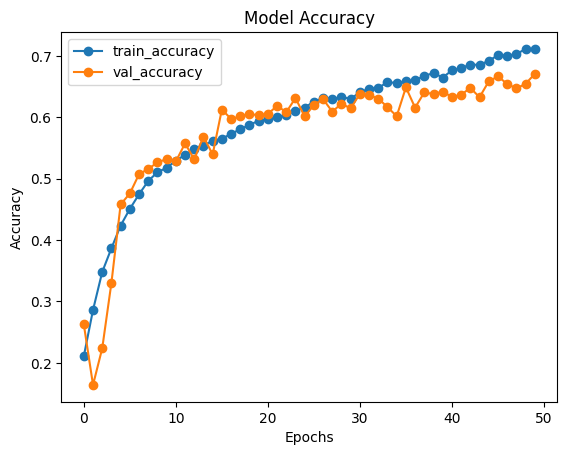

In [48]:
# Plotting model performance
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gradio Deployment

In [49]:
!pip3 install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing

In [59]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [93]:
# Ensure your model is loaded here
# model = ... # Load your trained model
# Load your pre-trained model
model = tf.keras.models.load_model('/content/Custom_CNN_model.keras')

In [102]:
# Emotion labels dictionary
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 5, 'neutral': 3, 'sad': 4, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 5: 'happy',
 3: 'neutral',
 4: 'sad',
 6: 'surprise'}

In [103]:
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    # Resize the image to 48x48 pixels
    img = img_pil.resize((48, 48))

    # If the model expects grayscale images, convert the image to grayscale
    img = img.convert('L')

    # Convert the image to a numpy array
    img_array = img_to_array(img)

    # Add a batch dimension (i.e., convert the image to a 4D tensor)
    img_array = np.expand_dims(img_array, axis=0)

    # Rescale pixel values to [0, 1] (normalize the data)
    img_array /= 255.0

    return img_array

In [104]:
# Define the Gradio interface
def predict_emotion(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)
    # Get the emotion label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    predicted_emotion = index_to_emotion.get(predicted_class[0], "Unknown Emotion")
    return predicted_emotion

In [105]:
interface = gr.Interface(
    fn=predict_emotion,  # Your prediction function
    inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
    outputs="text",  # Output as text displaying the predicted emotion
    title="Emotion Detection",
    description="Upload an image and see the predicted emotion."
)

# Launch the Gradio interface
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ed2e059a9b8bf29bea.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
